In [204]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import random
import pandas as pd
from copy import  copy
import scipy.stats as st
import seaborn as sns
from pynverse import inversefunc
from scipy.optimize import least_squares
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import accuracy_score

from functools import reduce
from scipy import interpolate
from pomegranate import *
import networkx as nx
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BDeuScore, K2Score, BicScore
import scipy.special as sps
from pgmpy.base import DAG
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from pgmpy.inference import VariableElimination

import warnings
warnings.filterwarnings('ignore')

In [185]:
df = pd.read_csv('../data/all_stocks_5yr.csv')

In [186]:
df

date   open   high    low  close    volume Name
0       2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1       2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2       2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3       2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4       2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL
...            ...    ...    ...    ...    ...       ...  ...
619035  2018-02-01  76.84  78.27  76.69  77.82   2982259  ZTS
619036  2018-02-02  77.53  78.12  76.73  76.78   2595187  ZTS
619037  2018-02-05  76.64  76.92  73.18  73.83   2962031  ZTS
619038  2018-02-06  72.74  74.56  72.13  73.27   4924323  ZTS
619039  2018-02-07  72.70  75.00  72.69  73.86   4534912  ZTS

[619040 rows x 7 columns]

In [187]:
apple_volumes = df[df['Name'] == 'AAPL']['volume']
apple_prices_open = df[df['Name'] == 'AAPL']['open']
jp_morgan_high = df[df['Name'] == 'JPM']['high']

ed_prices_open = df[df['Name'] == 'ED']['open']
mkc_prices_open = df[df['Name'] == 'MKC']['open']
eqix_prices_open = df[df['Name'] == 'EQIX']['open']

In [188]:
apple_volumes -= apple_volumes.min()
apple_volumes /= apple_volumes.max()

### Apple volumes data

In [189]:
x = np.linspace(apple_volumes.min(), apple_volumes.max(), 100)
args_mle = st.gamma.fit(apple_volumes)
pdf = st.gamma.pdf(x, *args_mle)

In [190]:
args_mle

(1.8681386908698774, -0.0004588971430994701, 0.0894873095544805)

In [191]:
a, loc, scale = args_mle

PDF of Apple volumes data

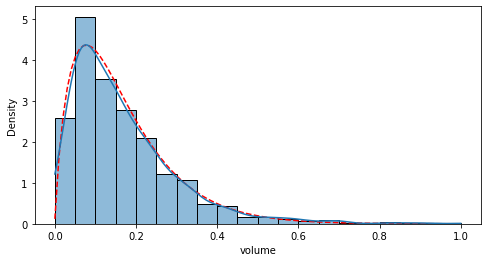

In [192]:
f, (ax_hist) = plt.subplots(1, sharex=True, figsize=(8, 4))
ax_hist.plot(x, pdf, 'r--', label='Estimated with MLE and Gamma distribution')
plot = sns.histplot(apple_volumes, bins=20, kde=True, stat='density', ax=ax_hist)
plt.show()

### Built-in sample method

In [193]:
N_samples = 100

In [194]:
samples_np = np.random.gamma(shape=a, scale=scale, size=N_samples)

In [195]:
shape = a

Vizualization of sampling

In [196]:
def show_samples_gamma(samples):
    plt.figure(figsize=(8,4))
    sns.histplot(samples,bins=20, kde=True)
    # plt.hist(gm_samples, bins=200, kde=True, density=True)
    plt.show()
#     count, bins, ignored = plt.hist(samples, 20, density=True)
#     y = bins**(shape-1)*(np.exp(-bins/scale) / (sps.gamma(shape)*scale**shape))
#     ax_hist.plot(x, 'r--', label='Estimated with MLE and Gamma distribution')
#     plt.plot(bins, y, linewidth=2, color='r')
#     plt.show()

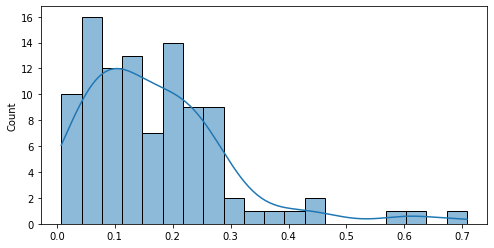

In [197]:
show_samples_gamma(samples_np)

### Inverse-transform method

In [198]:
def sample(gamma=False, gm=False, min_v=None, max_v=None):
    if gamma:
        x = np.linspace(0.0,1.0, N_samples)
        y = st.gamma.pdf(x, *args_mle) 
        cdf_y = np.cumsum(y) 
        cdf_y = cdf_y/cdf_y.max() 
    elif gm:
        x = np.linspace(min_v,max_v, N_samples)
        y = mix_pdf(x, pi, mu, sigma) 
        cdf_y = mix_cdf(x, pi, mu, sigma)
    inverse_cdf = interpolate.interp1d(cdf_y,x,fill_value="extrapolate")
    return inverse_cdf

In [199]:
def return_samples(gamma=False, gm=False, min_v=None, max_v=None):
    uniform_samples = random(N_samples)
    required_samples = sample(gamma, gm, min_v, max_v)(uniform_samples)
    return required_samples

In [200]:
samples_inverse_transform = return_samples(gamma=True)

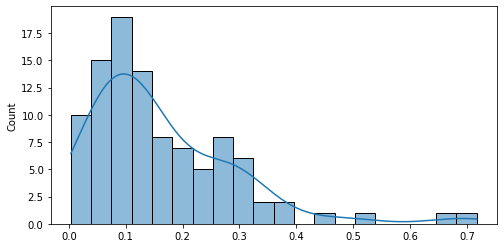

In [201]:
show_samples_gamma(samples_inverse_transform)

### Quality of sampled variables

In [202]:
# Inverse-transform
print('Inverse-transform method')
print(st.kstest(apple_volumes, samples_inverse_transform))

# Built-in method
print('\nBuilt-in numpy method')
print(st.kstest(apple_volumes, samples_np))

# Mann Whitney U
print(st.mannwhitneyu(x=apple_volumes, y=samples_np))
print(st.mannwhitneyu(x=apple_volumes, y=samples_inverse_transform))

Inverse-transform method
KstestResult(statistic=0.05198570293884035, pvalue=0.9515812129529675)

Built-in numpy method
KstestResult(statistic=0.08733915806195393, pvalue=0.45245832907286687)
MannwhitneyuResult(statistic=60479.0, pvalue=0.25654842564038505)
MannwhitneyuResult(statistic=61802.0, pvalue=0.38064726736976423)


In [203]:
len(apple_volumes)

1259

### Apple open price data

In [111]:
q = np.linspace(0.01, 0.95)

def mix_fun(f, x, pi, mu, sigma):
    d = np.zeros_like(x)
    for pi_i, mu_i, sigma_i in zip(pi, mu, sigma):
        d += pi_i * f(x, loc=mu_i, scale=sigma_i)
    return d

def mix_pdf(x, pi, mu, sigma):
    return mix_fun(st.norm.pdf, x, pi, mu, sigma)

def mix_cdf(x, pi, mu, sigma):
    return mix_fun(st.norm.cdf, x, pi, mu, sigma)

In [112]:
K = 5

mix = GaussianMixture(n_components=K, random_state=1).fit(apple_prices_open.to_numpy().reshape(-1, 1))
pi, mu, sigma = mix.weights_.flatten(), mix.means_.flatten(), np.sqrt(mix.covariances_.flatten())

x = np.linspace(apple_prices_open.min(), apple_prices_open.max(), num=100)
pdf = mix_pdf(x, pi, mu, sigma)

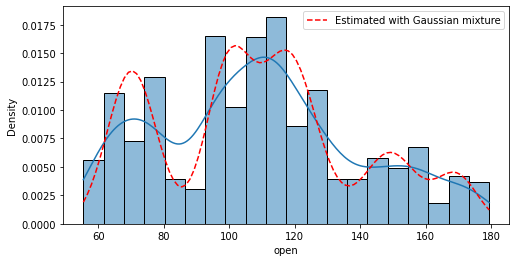

In [113]:
f, (ax_hist) = plt.subplots(1, sharex=True, figsize=(8, 4))
sns.histplot(apple_prices_open,bins=20, kde=True, stat='density', ax=ax_hist)
ax_hist.plot(x, pdf, 'r--', label='Estimated with Gaussian mixture')
ax_hist.legend()
plt.show()

Vizualization of sampling

In [114]:
def show_samples_gm(samples):
    plt.figure(figsize=(8,4))
    sns.histplot(samples,bins=20, kde=True)
    # plt.hist(gm_samples, bins=200, kde=True, density=True)
    plt.show()

In [115]:
gm_samples = mix.sample(N_samples)[0]
gm_samples = [sample[0] for sample in gm_samples]

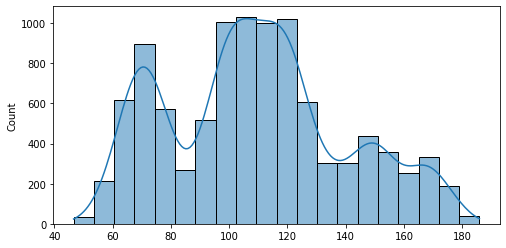

In [116]:
show_samples_gm(gm_samples)

In [117]:
gm_samples_inverse_transform = return_samples(gm=True, min_v=apple_prices_open.min(), max_v=apple_prices_open.max())

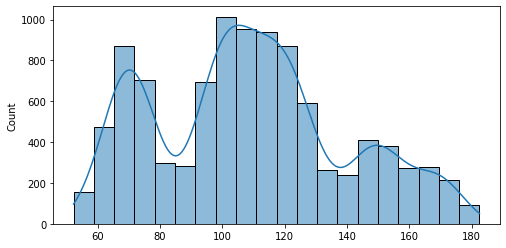

In [118]:
show_samples_gm(gm_samples_inverse_transform)

### Quality of sampled variables

In [119]:
# Inverse-transform
print('Inverse-transform method')
print(st.kstest(apple_prices_open, gm_samples_inverse_transform))

# Built-in method
print('\nBuilt-in numpy method')
print(st.kstest(apple_prices_open, gm_samples))

# Mann Whitney U
print(st.mannwhitneyu(x=apple_prices_open, y=gm_samples))
print(st.mannwhitneyu(x=apple_prices_open, y=gm_samples_inverse_transform))
# print(st.mannwhitneyu(x=gm_samples_inverse_transform, y=gm_samples, alternative='two-sided'))

Inverse-transform method
KstestResult(statistic=0.02766942017474186, pvalue=0.3517182469590415)

Built-in numpy method
KstestResult(statistic=0.02561056393963463, pvalue=0.44744997799017616)
MannwhitneyuResult(statistic=6264869.0, pvalue=0.3908079583778313)
MannwhitneyuResult(statistic=6279235.0, pvalue=0.442339516904674)


## JP Morgan high prices

In [167]:
K = 2
mix = GaussianMixture(n_components=K, random_state=1, max_iter=100).fit(jp_morgan_high.to_numpy().reshape(-1, 1))
pi, mu, sigma = mix.weights_.flatten(), mix.means_.flatten(), np.sqrt(mix.covariances_.flatten())

x = np.linspace(jp_morgan_high.min(), jp_morgan_high.max(), 100)
pdf = mix_pdf(x, pi, mu, sigma)

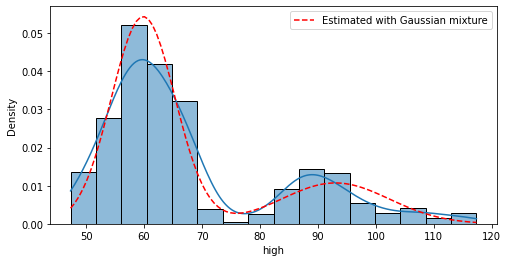

In [168]:
f, (ax_hist) = plt.subplots(1, sharex=True, figsize=(8, 4))
sns.histplot(jp_morgan_high, bins=16, kde=True, stat='density', ax=ax_hist)
ax_hist.plot(x, pdf, 'r--', label='Estimated with Gaussian mixture')
ax_hist.legend()
plt.show()

In [169]:
gm_samples = mix.sample(N_samples)[0]
gm_samples = [sample[0] for sample in gm_samples]

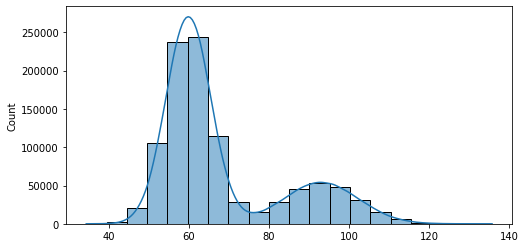

In [170]:
show_samples_gm(gm_samples)

In [171]:
gm_samples_inverse_transform = return_samples(gm=True, min_v=jp_morgan_high.min(), max_v=jp_morgan_high.max())

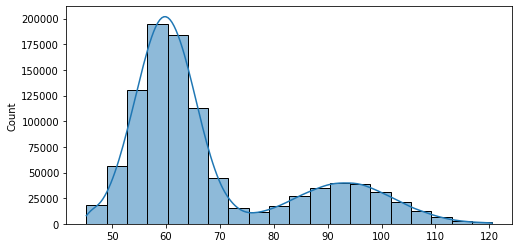

In [172]:
show_samples_gm(gm_samples_inverse_transform)

### Quality of sampled variables

In [173]:
# Inverse-transform
print('Inverse-transform method')
print(st.kstest(jp_morgan_high, gm_samples_inverse_transform))

# Built-in method
print('\nBuilt-in gm method')
print(st.kstest(jp_morgan_high, gm_samples))

# Mann Whitney U
# print(st.mannwhitneyu(x=gm_samples_inverse_transform, y=gm_samples, alternative='two-sided'))
print(st.mannwhitneyu(x=jp_morgan_high, y=gm_samples))
print(st.mannwhitneyu(x=jp_morgan_high, y=gm_samples_inverse_transform))

Inverse-transform method
KstestResult(statistic=0.03646390071485306, pvalue=0.06895768391167623)

Built-in gm method
KstestResult(statistic=0.035955900714852995, pvalue=0.07566720202443533)
MannwhitneyuResult(statistic=629297742.0, pvalue=0.49212789571140814)
MannwhitneyuResult(statistic=629416613.0, pvalue=0.4967543226490707)


## Open prices data (target variables samples)

In [79]:
open_prices = [ed_prices_open, mkc_prices_open, eqix_prices_open]

### ED open price

In [128]:
K = 5

mix = GaussianMixture(n_components=K, random_state=1).fit(ed_prices_open.to_numpy().reshape(-1, 1))
pi, mu, sigma = mix.weights_.flatten(), mix.means_.flatten(), np.sqrt(mix.covariances_.flatten())

x = np.linspace(ed_prices_open.min(), ed_prices_open.max(), num=100)
pdf = mix_pdf(x, pi, mu, sigma)

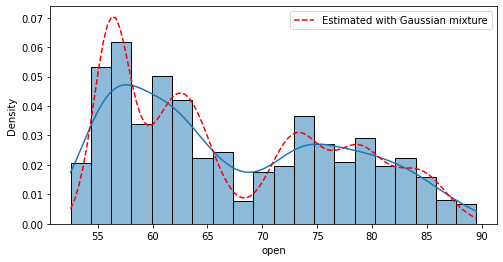

In [129]:
f, ax_hist = plt.subplots(1, sharex=True, figsize=(8, 4))
sns.histplot(ed_prices_open,bins=20, kde=True, stat='density', ax=ax_hist)
ax_hist.plot(x, pdf, 'r--', label='Estimated with Gaussian mixture')
ax_hist.legend()
plt.show()

### Built-in sample method

In [130]:
gm_samples_1 = mix.sample(N_samples)[0]
gm_samples_1 = [sample[0] for sample in gm_samples_1]

In [131]:
gm_samples_1

[57.71010485641811,
 52.48355253061294,
 59.161424598880956,
 55.025630577279834,
 56.80840857420849,
 55.87033715162825,
 58.69486590377738,
 52.88194236183919,
 55.749784722804634,
 55.64806219266707,
 58.15299428790067,
 54.466684709339624,
 55.997318232236935,
 54.83311539235943,
 56.35155139242718,
 57.243730028769775,
 54.46548340727033,
 58.17107260259382,
 57.76981942065224,
 57.11117291796688,
 57.76860679486079,
 55.15349768458004,
 56.079072966462,
 54.737542267350946,
 55.839776561167454,
 57.15715337595177,
 55.14040567930367,
 55.62710418419579,
 55.147812510409096,
 54.887003721044906,
 55.174096835797954,
 56.26098321871392,
 54.43793722497602,
 56.66875081770371,
 59.021129497719514,
 57.506512639156426,
 55.96528942823692,
 54.81699062562357,
 55.04881561825657,
 59.07501724465069,
 56.36573446602227,
 55.23062193277444,
 56.596960481906436,
 59.74802859927653,
 56.48018783097713,
 57.30048190242398,
 56.77726859409542,
 55.70055058654895,
 54.39633559038206,
 55.7053

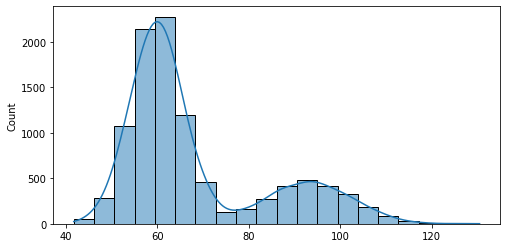

In [132]:
show_samples_gm(gm_samples)

### Inverse-transform sampling

In [133]:
gm_samples_inverse_transform_1 = return_samples(gm=True, min_v=ed_prices_open.min(), max_v=ed_prices_open.max())

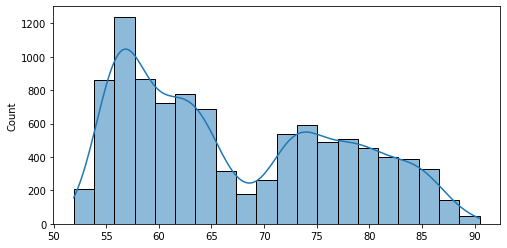

In [134]:
show_samples_gm(gm_samples_inverse_transform_1)

### Quality of sampled variables

In [135]:
# Inverse-transform
print('Inverse-transform method')
print(st.kstest(ed_prices_open, gm_samples_inverse_transform))

# Built-in method
print('\nBuilt-in gm method')
print(st.kstest(ed_prices_open, gm_samples))

# Mann Whitney U
print(st.mannwhitneyu(x=ed_prices_open, y=gm_samples_1))
print(st.mannwhitneyu(x=ed_prices_open, y=gm_samples_inverse_transform_1))
# print(st.mannwhitneyu(x=gm_samples_inverse_transform, y=gm_samples, alternative='two-sided'))

Inverse-transform method
KstestResult(statistic=0.16502009531374107, pvalue=1.1102230246251565e-15)

Built-in gm method
KstestResult(statistic=0.17089444003177126, pvalue=1.1102230246251565e-15)
MannwhitneyuResult(statistic=6271817.0, pvalue=0.4155507049216608)
MannwhitneyuResult(statistic=6259239.0, pvalue=0.3710731923104623)


### MKC open price

In [136]:
K = 5

mix = GaussianMixture(n_components=K, random_state=1).fit(mkc_prices_open.to_numpy().reshape(-1, 1))
pi, mu, sigma = mix.weights_.flatten(), mix.means_.flatten(), np.sqrt(mix.covariances_.flatten())

x = np.linspace(mkc_prices_open.min(), mkc_prices_open.max(), num=100)
pdf = mix_pdf(x, pi, mu, sigma)

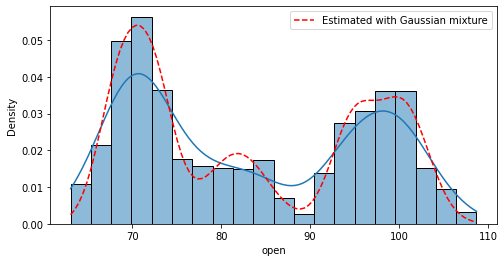

In [137]:
f, ax_hist = plt.subplots(1, sharex=True, figsize=(8, 4))
sns.histplot(mkc_prices_open,bins=20, kde=True, stat='density', ax=ax_hist)
ax_hist.plot(x, pdf, 'r--', label='Estimated with Gaussian mixture')
ax_hist.legend()
plt.show()

### Built-in sample method

In [138]:
gm_samples = mix.sample(N_samples)[0]
gm_samples = [sample[0] for sample in gm_samples]

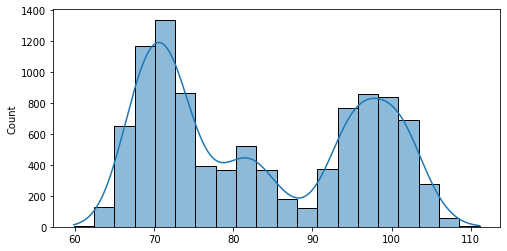

In [139]:
show_samples_gm(gm_samples)

### Inverse-transform sampling

In [140]:
gm_samples_inverse_transform = return_samples(gm=True, min_v=mkc_prices_open.min(), max_v=mkc_prices_open.max())

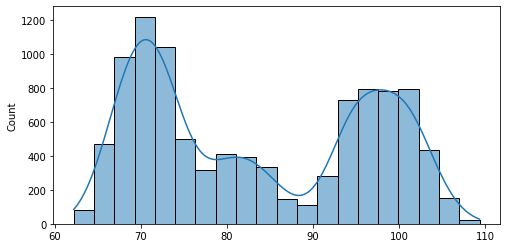

In [141]:
show_samples_gm(gm_samples_inverse_transform)

### Quality of sampled variables

In [143]:
# Inverse-transform
print('Inverse-transform method')
print(st.kstest(mkc_prices_open, gm_samples_inverse_transform))

# Built-in method
print('\nBuilt-in gm method')
print(st.kstest(mkc_prices_open, gm_samples))

# Mann Whitney U
# print(st.mannwhitneyu(x=gm_samples, y=gm_samples_inverse_transform, alternative='two-sided'))
print(st.mannwhitneyu(x=mkc_prices_open, y=gm_samples))
print(st.mannwhitneyu(x=mkc_prices_open, y=gm_samples_inverse_transform))

Inverse-transform method
KstestResult(statistic=0.01987227958697379, pvalue=0.7604855295532773)

Built-in gm method
KstestResult(statistic=0.01626084193804607, pvalue=0.9236458163094963)
MannwhitneyuResult(statistic=6293869.0, pvalue=0.49585063762090054)
MannwhitneyuResult(statistic=6228422.0, pvalue=0.27008952821831944)


### EQIX open price

In [144]:
K = 5

mix = GaussianMixture(n_components=K, random_state=1).fit(eqix_prices_open.to_numpy().reshape(-1, 1))
pi, mu, sigma = mix.weights_.flatten(), mix.means_.flatten(), np.sqrt(mix.covariances_.flatten())

x = np.linspace(eqix_prices_open.min(), eqix_prices_open.max(), num=100)
pdf = mix_pdf(x, pi, mu, sigma)

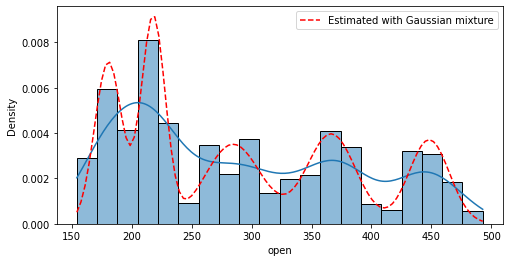

In [145]:
f, ax_hist = plt.subplots(1, sharex=True, figsize=(8, 4))
sns.histplot(eqix_prices_open,bins=20, kde=True, stat='density', ax=ax_hist)
ax_hist.plot(x, pdf, 'r--', label='Estimated with Gaussian mixture')
ax_hist.legend()
plt.show()

### Built-in sample method

In [146]:
gm_samples = mix.sample(N_samples)[0]
gm_samples = [sample[0] for sample in gm_samples]

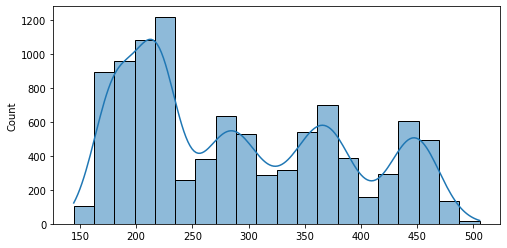

In [147]:
show_samples_gm(gm_samples)

### Inverse-transform sampling

In [148]:
gm_samples_inverse_transform = return_samples(gm=True, min_v=eqix_prices_open.min(), max_v=eqix_prices_open.max())

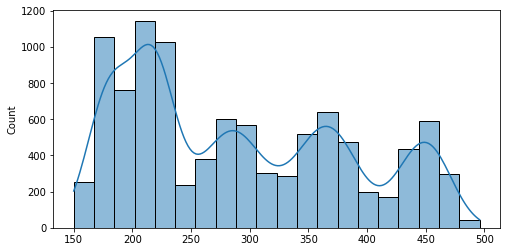

In [150]:
show_samples_gm(gm_samples_inverse_transform)

### Quality of sampled variables

In [151]:
# Inverse-transform
print('Inverse-transform method')
print(st.kstest(eqix_prices_open, gm_samples_inverse_transform))

# Built-in method
print('\nBuilt-in gm method')
print(st.kstest(eqix_prices_open, gm_samples))

# Mann Whitney U
# print(st.mannwhitneyu(x=gm_samples, y=gm_samples_inverse_transform, alternative='two-sided'))
print(st.mannwhitneyu(x=eqix_prices_open, y=gm_samples))
print(st.mannwhitneyu(x=eqix_prices_open, y=gm_samples_inverse_transform))

Inverse-transform method
KstestResult(statistic=0.02174988085782367, pvalue=0.656236474548072)

Built-in gm method
KstestResult(statistic=0.01604988085782367, pvalue=0.9305110917502168)
MannwhitneyuResult(statistic=6287948.0, pvalue=0.47413600748951235)
MannwhitneyuResult(statistic=6284931.0, pvalue=0.46309691851650703)


## Correlations

<AxesSubplot:>

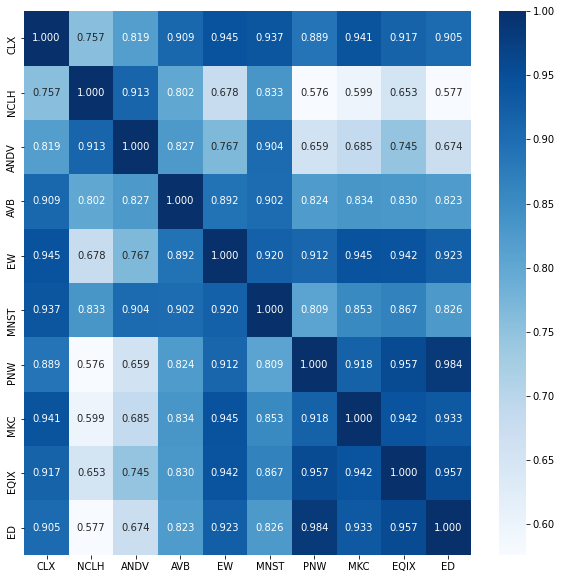

In [206]:
def get_company_data(data, name):
    return data.loc[data.Name == name].drop(['Name'], axis=1)


tech_companies_X = ['CLX', 'NCLH', 'ANDV', 'AVB', 'EW', 'MNST', 'PNW', 'MKC', 'EQIX']
tech_companies_y = ['ED']

tech_comp_data_X = df[df.Name.isin(tech_companies_X)]
tech_comp_data_y = df[df.Name.isin(tech_companies_y)]
open_data = tech_comp_data_X[['open', 'Name','date']]

train_companies_data = [get_company_data(open_data, company) for company in tech_companies_X]

merge = None
for i in range(1,len(tech_companies_X)) :
    if merge is None:
        merge = pd.merge(train_companies_data[i-1], train_companies_data[i], on='date', suffixes=(f'_{tech_companies_X[i-1]}', f'_{tech_companies_X[i]}'))
    else:
        merge = pd.merge(merge, train_companies_data[i], on='date', suffixes=(f'_{tech_companies_X[i-1]}', f'_{tech_companies_X[i]}'))
        
X = merge.drop(['date'], axis=1)
y = tech_comp_data_y['open']

stacked = np.hstack((X.to_numpy(), y.to_numpy().reshape(-1, 1)))
corr = np.corrcoef(stacked.T)
f, ax = plt.subplots(figsize=(10, 10))
labels = tech_companies_X + tech_companies_y
sns.heatmap(corr, annot=True, fmt= '.3f', ax = ax, cmap = 'Blues', xticklabels=labels, yticklabels=labels)

## Bayesian networks

In [207]:
tech_companies = ['CLX', 'NCLH', 'ANDV', 'AVB', 'EW', 'MNST', 'PNW', 'MKC', 'EQIX', 'ED']

tech_comp_data_X = df[df.Name.isin(tech_companies)]
open_data = tech_comp_data_X[['open', 'Name','date']]

train_companies_data = [get_company_data(open_data, company) for company in tech_companies]

merge = None
for i in range(1,len(tech_companies)) :
    if merge is None:
        merge = pd.merge(train_companies_data[i-1], train_companies_data[i], on='date', suffixes=(f'_{tech_companies[i-1]}', f'_{tech_companies[i]}'))
    else:
        merge = pd.merge(merge, train_companies_data[i], on='date', suffixes=(f'_{tech_companies[i-1]}', f'_{tech_companies[i]}'))

In [208]:
df_network = merge.drop(['date'], axis=1)

In [209]:
df_network

open_CLX  open_NCLH  open_ANDV  open_AVB  open_EW  open_MNST  open_PNW  \
0        80.78      27.60      52.46    127.51   43.185    16.0933     53.60   
1        80.52      27.78      54.44    128.84   43.510    15.6500     53.97   
2        80.63      28.91      54.70    129.63   43.520    15.8033     54.16   
3        80.75      28.81      53.55    131.10   43.730    15.5567     54.52   
4        81.02      28.82      54.15    129.41   43.485    15.8967     54.45   
...        ...        ...        ...       ...      ...        ...       ...   
1254    141.58      60.77     108.10    169.91  126.490    67.9700     79.63   
1255    134.92      60.49     105.66    158.68  133.760    67.6600     77.90   
1256    130.20      59.53     102.00    163.88  130.840    66.5800     77.62   
1257    125.62      55.99      97.48    157.41  125.060    63.1000     75.27   
1258    130.81      57.93     102.87    159.84  126.750    63.7300     75.22   

      open_MKC  open_EQIX  open_ED  
0        63.66     214.99    57.12  
1        63.69     217.77    56.56  
2        64.09     216.32    56.72  
3        64.50     212.70    56.58  
4        64.25     223.31    56.46  
...        ...        ...      ...  
1254    108.71     452.69    80.39  
1255    106.99     442.00    78.48  
1256    103.39     436.98    77.88  
1257    100.52     427.31    76.10  
1258    102.04     430.00    75.79  

[1259 rows x 10 columns]

In [210]:
columns = [f'open_{comp}' for comp in tech_companies]

In [211]:
transformed_data = copy(df_network)
est = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='kmeans')
data_discrete = est.fit_transform(df_network.values[:,0:10])
transformed_data[columns] = data_discrete

In [212]:
avg_values = [[] for i in range(10)]

for j in range(len(est.bin_edges_)):
    edges = est.bin_edges_[j]
    for i in range(len(edges)-1):
        avg_value = (edges[i] + edges[i+1])/2
        avg_values[j].append(avg_value)

Sampling function for Directed Graphical Model

In [213]:
def sampling(bn: DAG, data: pd.DataFrame, n: int = 1000):
    bn_new = BayesianModel(bn.edges())
    bn_new.fit(data)
    sampler = BayesianModelSampling(bn_new)
    sample = sampler.forward_sample(size=n, return_type='dataframe')
    return sample

Drawing comparative histograms function

In [214]:
def draw_comparative_hist (parametr: str, original_data: pd.DataFrame, data_sampled: pd.DataFrame):
    final_df = pd.DataFrame()
    df1 = pd.DataFrame()
    df1[parametr] = original_data[parametr]
    df1['Data'] = 'Original data'
    df1['Probability'] = df1[parametr].apply(lambda x: (df1.groupby(parametr)[parametr].count()[x])/original_data.shape[0])
    df2 = pd.DataFrame()
    df2[parametr] = data_sampled[parametr]
    df2['Data'] = 'Synthetic data'
    df2['Probability'] = df2[parametr].apply(lambda x: (df2.groupby(parametr)[parametr].count()[x])/data_sampled.shape[0])
    final_df = pd.concat([df1, df2])
    sns.barplot(x=parametr, y="Probability", hue="Data", data=final_df)
    plt.show()

Accuracy calculation function

In [215]:
def accuracy_params_restoration(bn: BayesianModel, data: pd.DataFrame):
    bn.fit(data)
    result = pd.DataFrame(columns=['Parameter', 'Accuracy'])
    bn_infer = VariableElimination(bn)
    for j, param in enumerate(data.columns):
        accuracy = 0
        test_param = data[param]
        test_data = data.drop(columns=param)
        evidence = test_data.to_dict('records')
        predicted_param = []
        for element in evidence:
            prediction = bn_infer.map_query(variables=[param], evidence=element)
            predicted_param.append(prediction[param])
        accuracy = accuracy_score(test_param.values, predicted_param)
        result.loc[j,'Parameter'] = param
        result.loc[j, 'accuracy'] = accuracy
    return result

Transform discrete data to continuous

In [216]:
def transform_to_cont(df: pd.DataFrame):
    for i in range(len(columns)):
        series = df[columns[i]]
        avgs = [avg_values[i][0] if value == 0.0 else 
                avg_values[i][1] if value == 1.0 else 
                 avg_values[i][2] if value == 2.0 else 
                  avg_values[i][3] if value == 3.0 else 
                avg_values[i][4] if value == 4.0 else
                avg_values[i][5] if value == 5.0 else
                avg_values[i][6] if value == 6.0 else
                avg_values[i][7] if value == 7.0
                  else None for value in series]
                  
        df[columns[i]] = avgs
    return df

### Choosing structure on the basis of multivariate analysis

In [217]:
model = BayesianModel([
                       ('open_EW', 'open_MKC'), ('open_EQIX', 'open_MKC'),
                       ('open_ED', 'open_EQIX'), ('open_PNW', 'open_EQIX'),
                       ('open_PNW', 'open_ED'),
                       ('open_EW', 'open_CLX'), ('open_MKC', 'open_CLX'), 
                       ('open_ANDV', 'open_NCLH'), ('open_MNST', 'open_NCLH'),
                       ('open_AVB', 'open_ANDV'), ('open_MNST', 'open_ANDV'),
                       ('open_CLX', 'open_AVB'), ('open_MNST', 'open_AVB'),
                       ('open_EQIX', 'open_EW'), ('open_ED', 'open_EW'),
                       ('open_CLX', 'open_MNST'), ('open_EW', 'open_MNST')
                      ])

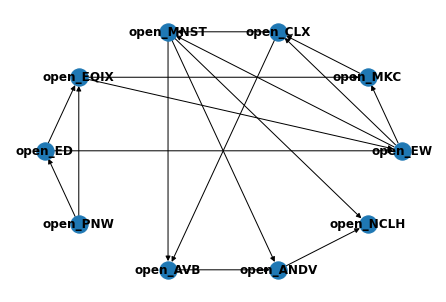

In [218]:
G_K2 = nx.DiGraph()
G_K2.add_edges_from(model.edges())
pos = nx.layout.circular_layout(G_K2)
nx.draw(G_K2, pos, with_labels=True,font_weight='bold')

In [219]:
sample_k2 = sampling(model, transformed_data, 1000)

Generating for node: open_NCLH: 100%|██████████| 10/10 [00:00<00:00, 91.01it/s]


In [220]:
sample_k2

open_PNW  open_ED  open_EQIX  open_EW  open_MKC  open_CLX  open_MNST  \
0         1.0      1.0        1.0      1.0       1.0       0.0        1.0   
1         2.0      3.0        3.0      2.0       3.0       3.0        4.0   
2         0.0      0.0        0.0      1.0       1.0       0.0        0.0   
3         2.0      1.0        1.0      0.0       1.0       0.0        1.0   
4         2.0      2.0        1.0      2.0       1.0       2.0        3.0   
..        ...      ...        ...      ...       ...       ...        ...   
995       5.0      5.0        5.0      5.0       5.0       6.0        7.0   
996       1.0      1.0        0.0      0.0       0.0       1.0        0.0   
997       0.0      0.0        1.0      1.0       0.0       1.0        1.0   
998       1.0      1.0        1.0      2.0       1.0       2.0        3.0   
999       2.0      1.0        1.0      3.0       1.0       3.0        4.0   

     open_AVB  open_ANDV  open_NCLH  
0         0.0        0.0        0.0  
1         4.0        5.0        5.0  
2         0.0        1.0        0.0  
3         1.0        0.0        1.0  
4         4.0        3.0        2.0  
..        ...        ...        ...  
995       6.0        6.0        5.0  
996       0.0        0.0        0.0  
997       0.0        0.0        0.0  
998       3.0        3.0        3.0  
999       4.0        5.0        5.0  

[1000 rows x 10 columns]

In [223]:
cont_sample_k2 = transform_to_cont(sample_k2)

In [224]:
cont_sample_k2

open_PNW    open_ED   open_EQIX     open_EW   open_MKC    open_CLX  \
0    58.800982  59.807334  219.989555   47.474040  72.297061   84.012732   
1    63.692145  68.293102  299.463331   63.369384  84.589750  109.709715   
2    53.987658  55.214897  176.554446   47.474040  72.297061   84.012732   
3    63.692145  59.807334  219.989555   35.175203  72.297061   84.012732   
4    63.692145  63.732802  219.989555   63.369384  72.297061   99.631109   
..         ...        ...         ...         ...        ...         ...   
995  78.945424  78.124896  383.286087  102.729676  96.469885  136.188939   
996  58.800982  59.807334  176.554446   35.175203  66.400381   91.153675   
997  53.987658  55.214897  219.989555   47.474040  66.400381   91.153675   
998  58.800982  59.807334  219.989555   63.369384  72.297061   99.631109   
999  63.692145  59.807334  219.989555   77.673150  72.297061  109.709715   

     open_MNST    open_AVB   open_ANDV  open_NCLH  
0    23.676299  120.238135   47.027831  30.093092  
1    44.390942  162.626655   92.841019  53.752465  
2    18.035936  120.238135   55.815282  30.093092  
3    23.676299  130.892659   47.027831  34.369208  
4    38.039609  162.626655   74.303196  38.664534  
..         ...         ...         ...        ...  
995  64.475425  180.333654  103.144660  53.752465  
996  18.035936  120.238135   47.027831  30.093092  
997  23.676299  120.238135   47.027831  30.093092  
998  38.039609  151.586972   74.303196  43.965972  
999  44.390942  162.626655   92.841019  53.752465  

[1000 rows x 10 columns]

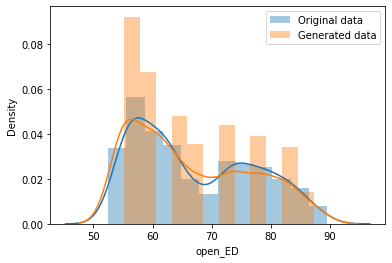

In [225]:
sns.distplot(df_network['open_ED'], label='Original data')
sns.distplot(cont_sample_k2['open_ED'], label='Generated data')
plt.legend()

In [230]:
# Kolmogorov-Smirnov test
print(st.kstest(df_network['open_ED'], cont_sample_k2['open_ED']))

# Mann Whitney U
print(st.mannwhitneyu(x=df_network['open_ED'], y=cont_sample_k2['open_ED']))

KstestResult(statistic=0.16339475774424145, pvalue=1.8418599978531347e-13)
MannwhitneyuResult(statistic=601518.0, pvalue=0.034431566696177626)


### Hill Climbing Search

#### K2 score

In [231]:
hc = HillClimbSearch(transformed_data, scoring_method=K2Score(transformed_data))
best_model = hc.estimate()

  0%|          | 14/1000000 [00:01<28:21:26,  9.80it/s]


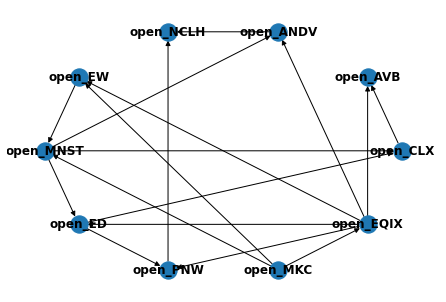

In [232]:
G_K2 = nx.DiGraph()
G_K2.add_edges_from(best_model.edges())
pos = nx.layout.circular_layout(G_K2)
nx.draw(G_K2, pos, with_labels=True,font_weight='bold')

In [233]:
best_model

In [234]:
sample_k2 = sampling(best_model, transformed_data, 1000)

Generating for node: open_NCLH: 100%|██████████| 10/10 [00:00<00:00, 95.70it/s]


In [235]:
sample_k2

open_MKC  open_EQIX  open_EW  open_MNST  open_ED  open_CLX  open_AVB  \
0         2.0        2.0      3.0        5.0      1.0       3.0       4.0   
1         6.0        5.0      4.0        4.0      5.0       6.0       6.0   
2         0.0        0.0      0.0        0.0      0.0       0.0       0.0   
3         5.0        7.0      6.0        6.0      6.0       6.0       7.0   
4         1.0        1.0      0.0        0.0      1.0       0.0       1.0   
..        ...        ...      ...        ...      ...       ...       ...   
995       1.0        1.0      1.0        0.0      1.0       0.0       0.0   
996       0.0        1.0      1.0        2.0      0.0       1.0       2.0   
997       0.0        0.0      0.0        0.0      0.0       1.0       1.0   
998       5.0        5.0      7.0        5.0      4.0       4.0       5.0   
999       3.0        3.0      3.0        5.0      3.0       4.0       6.0   

     open_PNW  open_ANDV  open_NCLH  
0         1.0        6.0        7.0  
1         5.0        4.0        4.0  
2         0.0        0.0        0.0  
3         7.0        6.0        5.0  
4         1.0        1.0        0.0  
..        ...        ...        ...  
995       2.0        1.0        0.0  
996       0.0        3.0        2.0  
997       0.0        1.0        0.0  
998       5.0        3.0        2.0  
999       3.0        6.0        7.0  

[1000 rows x 10 columns]

In [236]:
cont_sample_k2 = transform_to_cont(sample_k2)

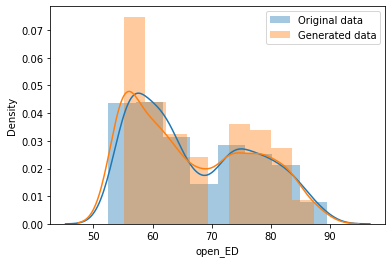

In [237]:
sns.distplot(df_network['open_ED'], label='Original data', bins=8)
sns.distplot(cont_sample_k2['open_ED'], label='Generated data')
plt.legend()

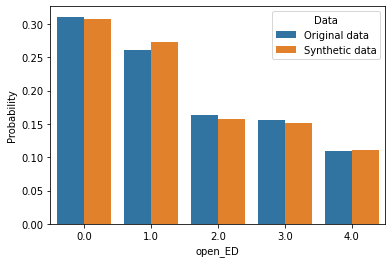

In [467]:
draw_comparative_hist('open_ED', transformed_data, sample_k2)

In [238]:
# Kolmogorov-Smirnov test
print(st.kstest(df_network['open_ED'], cont_sample_k2['open_ED']))

# Mann Whitney U
print(st.mannwhitneyu(x=df_network['open_ED'], y=cont_sample_k2['open_ED']))

KstestResult(statistic=0.18339475774424147, pvalue=7.21197690323002e-17)
MannwhitneyuResult(statistic=603500.0, pvalue=0.045454595099439866)


In [719]:
accuracy_k2 = accuracy_params_restoration(BayesianModel(best_model.edges()), transformed_data)

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it

KeyboardInterrupt: 

In [ ]:
accuracy_k2

#### Bic Score

In [239]:
hc_BicScore = HillClimbSearch(transformed_data, scoring_method=BicScore(transformed_data))
best_model_BicScore = hc_BicScore.estimate()

  0%|          | 17/1000000 [00:02<52:39:31,  5.27it/s]


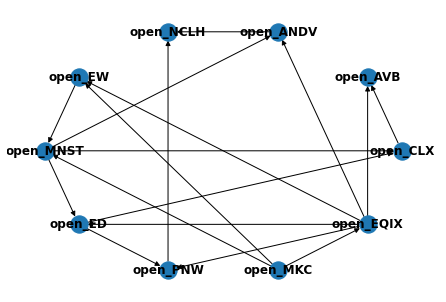

In [240]:
G_BicScore = nx.DiGraph()
G_BicScore.add_edges_from(best_model_BicScore.edges())
pos = nx.layout.circular_layout(G_BicScore)
nx.draw(G_BicScore, pos, with_labels=True,font_weight='bold')

In [241]:
sample_bic = sampling(best_model_BicScore, transformed_data, 1000)

Generating for node: open_NCLH: 100%|██████████| 10/10 [00:00<00:00, 92.09it/s]


In [242]:
cont_sample_bic = transform_to_cont(sample_bic)

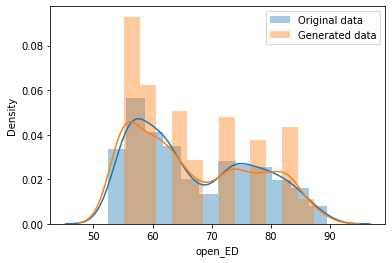

In [243]:
sns.distplot(df_network['open_ED'], label='Original data')
sns.distplot(cont_sample_bic['open_ED'], label='Generated data')
plt.legend()

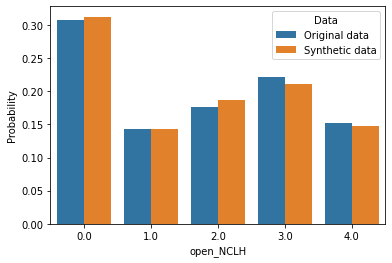

In [474]:
draw_comparative_hist('open_NCLH', transformed_data, sample_bic)

In [244]:
# Kolmogorov-Smirnov test
print(st.kstest(df_network['open_ED'], cont_sample_bic['open_ED']))

# Mann Whitney U
print(st.mannwhitneyu(x=df_network['open_ED'], y=cont_sample_bic['open_ED']))

KstestResult(statistic=0.16539475774424145, pvalue=8.881784197001252e-14)
MannwhitneyuResult(statistic=610718.0, pvalue=0.11101336120016242)


In [476]:
# accuracy_bic = accuracy_params_restoration(BayesianModel(best_model_BicScore.edges()), transformed_data)

#### BDeu Score

In [245]:
hc_BDeuScore = HillClimbSearch(transformed_data, scoring_method=BDeuScore(transformed_data))
best_model_BDeuScore = hc_BDeuScore.estimate()

  0%|          | 17/1000000 [00:01<25:08:52, 11.05it/s]


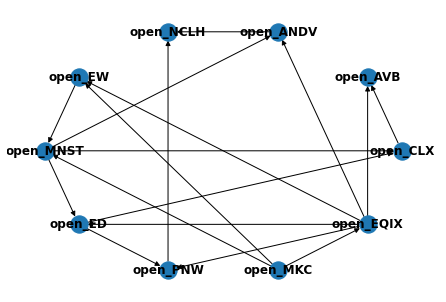

In [246]:
G_BDeuScore = nx.DiGraph()
G_BDeuScore.add_edges_from(best_model_BDeuScore.edges())
pos = nx.layout.circular_layout(G_BDeuScore)
nx.draw(G_BDeuScore, pos, with_labels=True,font_weight='bold')

In [247]:
sample_bdeu = sampling(best_model_BDeuScore, transformed_data, 1000)

Generating for node: open_NCLH: 100%|██████████| 10/10 [00:00<00:00, 91.99it/s]


In [248]:
cont_sample_bdeu = transform_to_cont(sample_bdeu)

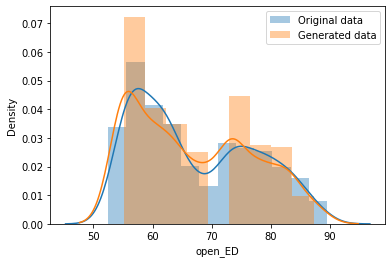

In [249]:
sns.distplot(df_network['open_ED'], label='Original data')
sns.distplot(cont_sample_bdeu['open_ED'], label='Generated data')
plt.legend()

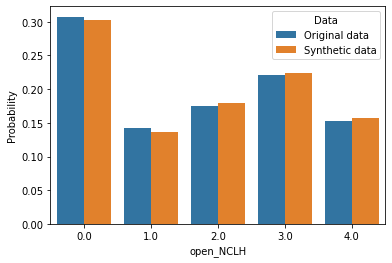

In [480]:
draw_comparative_hist('open_NCLH', transformed_data, sample_bdeu)

In [250]:
# Kolmogorov-Smirnov test
print(st.kstest(df_network['open_ED'], cont_sample_bdeu['open_ED']))

# Mann Whitney U
print(st.mannwhitneyu(x=df_network['open_ED'], y=cont_sample_bdeu['open_ED']))

KstestResult(statistic=0.17439475774424146, pvalue=9.992007221626409e-16)
MannwhitneyuResult(statistic=609816.0, pvalue=0.10029739318666664)


In [ ]:
# accuracy_dbeu = accuracy_params_restoration(BayesianModel(best_model_BDeuScore.edges()), transformed_data)